In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import tempfile
import matplotlib

from six.moves import urllib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.python.estimator.export import export_output
from tensorflow.examples.tutorials.mnist import input_data

tf.logging.set_verbosity(tf.logging.INFO)

LEARNING_RATE = 3e-5
DROPOUT = 0.5
MAX_STEPS = 2000

# DATA EXPLORATION

The MNIST dataset is composed by 60,000 training examples, 5,000 eval examples and 10,000 test examples of the handwritten digits 0–9, formatted as 28x28-pixel monochrome images. First of all, let's load the dataset from TensorFlow.

### Loading MNIST train, validation and test datasets

In [2]:
mnist = input_data.read_data_sets('dataset')

# Training examples
train_set = mnist.train

# Test examples
eval_set = mnist.validation

# Predict examples
test_set = mnist.test

Extracting dataset/train-images-idx3-ubyte.gz
Extracting dataset/train-labels-idx1-ubyte.gz
Extracting dataset/t10k-images-idx3-ubyte.gz
Extracting dataset/t10k-labels-idx1-ubyte.gz


### Lookin at the distribuition

On the followings plots we can see the distribution of handwritten digits images on each set is fairly homogeneous.

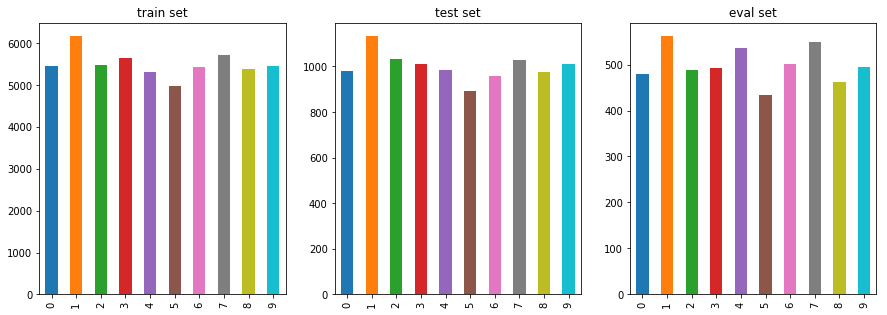

In [3]:
dic_set = {'train set': train_set, 'eval set': eval_set, 'test set': test_set}

plt.figure(figsize=(15,5))
for i, key in enumerate(dic_set):
    plt.subplot(131+i)
    plt.title(key)
    pd.DataFrame(dic_set[key].labels, columns=['']).groupby('').size().plot.bar()

### Looking at sample images

First, let's sample 10 handwritten digits images of each label, than let's plot those images. The resultant plot give us a feel for the complexity of this classification task.

In [4]:
def get_sample_img_id(labels, x):
    img_id = [i for i, e in enumerate(labels) if e == x]
    return np.random.choice(img_id, 10)

img_id = []
for x in range(10):
    img_id.extend(get_sample_img_id(eval_set.labels, x))
    
example_images = eval_set.images[img_id]

In [5]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

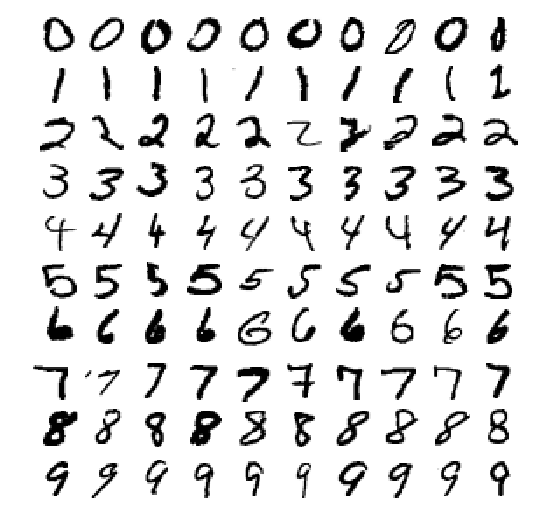

In [6]:
plt.figure(figsize=(9,9))
plot_digits(example_images, images_per_row=10)
plt.show()

# PREPROCESSING

Now we have some familiarity with our dataset, let's write some functions to automate the building of our model.
 
### Weight Initialization

In [7]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

### Convolution and Pooling layers

* padding could be "SAME" or "VALID"
* strides has shape [batch, height, width, channels]
* ksize has shape [batch, height, width, channels]

In [8]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# TENSORFLOW MODEL

Pre-made Estimators enable you to work at a much higher conceptual level than the base TensorFlow APIs. You no longer have to worry about creating the computational graph or sessions since Estimators handle all the "plumbing" for you. 

### Pre-made vs. custom

As the following figure shows, pre-made Estimators are subclasses of the tf.estimator.Estimator base class, while custom Estimators are an instance of tf.estimator.Estimator:

![](estimator_types.png "Pre-made and custom Estimators are all Estimators.")

Pre-made Estimators are fully baked. Sometimes though, you need more control over an Estimator's behavior. That's where custom Estimators come in. You can create a custom Estimator to do just about anything. 

Let's see how to solve the MNIST problem with a custom Estimator. You can find more information about how creating Custom Estimators on the following TensorFlow [tutorial](https://www.tensorflow.org/get_started/custom_estimators).

### Building the model function

A model function implements the ML algorithm. Let's implemment a simple Convolutional Neural Network model  with:
* A convolotional layer
* A pooling layer
* Another convolotional layer
* Another pooling layer
* A fully-connected layer
* A doop-out layer
* Another fully-connected layer

In [9]:
def model_fn(features, labels, mode, params):
  """Model function for Estimator."""

  # Input reshape
  # x_image has shape: [batch, in_height, in_width, in_channels]
  x_image = tf.reshape(features["x"], [-1, 28, 28, 1])

  # First Convolutional Layer
  # W_conv1 has shape: [filter_height, filter_width, in_channels, out_channels]
  W_conv1 = weight_variable([5, 5, 1, 32])
  b_conv1 = bias_variable([32])
  h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
  h_pool1 = max_pool_2x2(h_conv1)

  # Second Convolutional Layer
  # W_conv2 has shape: [filter_height, filter_width, in_channels, out_channels]
  W_conv2 = weight_variable([5, 5, 32, 64])
  b_conv2 = bias_variable([64])
  h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
  h_pool2 = max_pool_2x2(h_conv2)

  # Densely Connected Layer
  # W_fc1 has shape: [in_channels, out_channels]
  W_fc1 = weight_variable([7 * 7 * 64, 1024])
  b_fc1 = bias_variable([1024])
  h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  # Dropout
  is_training = tf.estimator.ModeKeys.TRAIN
  keep_prob = params["dropout"] if mode == is_training else 1.0
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # Readout Layer
  # W_fc2 has shape: [in_channels, out_channels]
  W_fc2 = weight_variable([1024, 10])
  b_fc2 = bias_variable([10])
  y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

  # Reshape output layer to 1-dim Tensor to return predictions
  predictions = tf.argmax(y_conv,1)

  # Provide an estimator spec for `ModeKeys.PREDICT`.
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(
        mode=mode, predictions={"digits": predictions},
        export_outputs={'': export_output.ClassificationOutput(
            scores=tf.nn.softmax(y_conv), classes=tf.as_string(list(range(10))))})

  # Calculate loss using tf.losses.softmax_cross_entropy
  loss = tf.losses.softmax_cross_entropy(tf.one_hot(labels, 10), y_conv)

  optimizer = tf.train.AdamOptimizer(learning_rate=params["learning_rate"])
  train_op = optimizer.minimize(loss=loss,
                                global_step=tf.train.get_global_step())

  # Calculate accuracy as additional eval metric
  eval_metric_ops = {
      "accu": tf.metrics.accuracy(tf.cast(labels, tf.float64), predictions)
  }

  # Provide an estimator spec for `ModeKeys.EVAL` and `ModeKeys.TRAIN` modes.
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, train_op=train_op, eval_metric_ops=eval_metric_ops)

### Seting the model parameters

The caller may pass params to an Estimator's constructor. Any params passed to the constructor are in turn passed on to the model_fn.

In [10]:
model_params = {"learning_rate": LEARNING_RATE,
                "dropout": DROPOUT}

### Instantiating the Estimator

In [11]:
run_config = tf.contrib.learn.RunConfig()
run_config = run_config.replace(model_dir='SavedModel')

cnn = tf.estimator.Estimator(model_fn=model_fn, params=model_params, config=run_config)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f868d7e8590>, '_model_dir': 'SavedModel', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}


### Building a generical input function

You must create input functions to supply data for training, evaluating, and prediction.

An input function is a function that returns a tf.data.Dataset object which outputs the following two-element tuple:

* features - A Python dictionary in which:
    * Each key is the name of a feature.
    * Each value is an array containing all of that feature's values.
* label - An array containing the values of the label for every example.

To keep things simple in this example we are going to load the data with numpy, and build our input pipeline from this in-memory data.

Here is a generical input function used to train, evaluate and test our model.

In [12]:
def input_fn(data_set, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.numpy_input_fn(
      x={"x": np.array(data_set.images)},
      y=np.array(data_set.labels),
      num_epochs=num_epochs,
      shuffle=shuffle)

# Training the model

In [13]:
cnn.train(input_fn=input_fn(train_set), steps=MAX_STEPS)

INFO:tensorflow:Calling model_fn.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from SavedModel/model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2 into SavedModel/model.ckpt.
INFO:tensorflow:loss = 10.050554, step = 2
INFO:tensorflow:global_step/sec: 17.3325
INFO:tensorflow:loss = 2.364644, step = 102 (5.772 sec)
INFO:tensorflow:global_step/sec: 18.9403
INFO:tensorflow:loss = 1.36491, step = 202 (5.280 sec)
INFO:tensorflow:global_step/sec: 17.2824
INFO:tensorflow:loss = 0.9320758, step = 302 (5.786 sec)
INFO:tensorflow:global_step/sec: 17.9556
INFO:tensorflow:loss = 0.5724587, step = 402 (5.571 sec)
INFO:te

# Evaluating the model

In [14]:
ev = cnn.evaluate(input_fn=input_fn(eval_set, num_epochs=1, shuffle=False))
print("Loss: %s" % ev["loss"])
print("Accuracy: %s" % ev["accu"])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-14-20:44:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from SavedModel/model.ckpt-2001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-14-20:44:13
INFO:tensorflow:Saving dict for global step 2001: accu = 0.9652, global_step = 2001, loss = 0.11818377
Loss: 0.11818377
Accuracy: 0.9652


# Predicting new examples

In [15]:
predictions = cnn.predict(input_fn=input_fn(test_set, num_epochs=1, shuffle=False))

pred = [p["digits"] for i, p in enumerate(predictions)]
labels = np.array(test_set.labels)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from SavedModel/model.ckpt-2001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Finaly, we can save the predictions as a .txt file in order to persist our predictions for post processing

In [16]:
output_name = 'predictions/pred_lr_{}_do_{}.txt'.format(LEARNING_RATE, DROPOUT)
pd.DataFrame(np.array([pred, labels]).transpose(), columns=['pred', 'labels']).to_csv(output_name)